<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/bellbranch/model-apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torch.optim as optim
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder

torch.cuda.empty_cache()


import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
def image_show(img):
    plt.imshow(img.permute(1, 2, 0)  )
#     image = transform(img)
#     plt.imshow(image.permute(1, 2, 3))

In [3]:

#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d manjuphoenix/appledataset

 95% 315M/333M [00:03<00:00, 88.0MB/s]
100% 333M/333M [00:03<00:00, 99.5MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'appledataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),
    transforms.RandomRotation(30),
])

# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Apple', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.75)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

The total number of images is: 1234
The number of images in a training set is: 39488
The number of images in a test set is: 6592
Dataset ImageFolder
    Number of datapoints: 26320
    Root location: /content/Apple
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomInvert(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust']


In [7]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


In [8]:
batch_size = 64
n_iters = 20000

In [9]:
#Creating a simple CNN architechture
class SimpleCustomCNN(nn.Module):
  def __init__(self):
    super(SimpleCustomCNN, self).__init__()

    #Defining a sequential model layers
    self.c1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=5, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.c2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
    self.fc1 = nn.Linear(in_features = 62*62*32, out_features = 4)

  def forward(self, x):
    output = self.c1(x)
    output = self.c2(output)
    output = output.reshape(output.size(0), -1)
    #or nn.Flatten()
    output = self.fc1(output)
    return output

model = SimpleCustomCNN()

learning_rate = 0.0001
#!pip install torch-summary 
#import torchsummary as summary
#print(summary(model, (3, 256, 256)))

In [10]:
print(model)

SimpleCustomCNN(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=123008, out_features=4, bias=True)
)


In [11]:
from tqdm import tqdm

def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [12]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [13]:
model = model.to(device)
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [14]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=45
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 1234/1234 [03:40<00:00,  5.59it/s]


Train Loss: 1.382 | Accuracy: 27.579


100%|██████████| 206/206 [00:35<00:00,  5.88it/s]


Test Loss: 1.379 | Accuracy: 34.119

Epoch : 2


100%|██████████| 1234/1234 [03:41<00:00,  5.58it/s]


Train Loss: 1.374 | Accuracy: 33.060


100%|██████████| 206/206 [00:34<00:00,  5.92it/s]


Test Loss: 1.368 | Accuracy: 34.681

Epoch : 3


100%|██████████| 1234/1234 [03:39<00:00,  5.61it/s]


Train Loss: 1.361 | Accuracy: 36.482


100%|██████████| 206/206 [00:34<00:00,  5.89it/s]


Test Loss: 1.353 | Accuracy: 46.976

Epoch : 4


100%|██████████| 1234/1234 [03:39<00:00,  5.61it/s]


Train Loss: 1.347 | Accuracy: 46.973


100%|██████████| 206/206 [00:35<00:00,  5.75it/s]


Test Loss: 1.336 | Accuracy: 47.143

Epoch : 5


100%|██████████| 1234/1234 [03:38<00:00,  5.65it/s]


Train Loss: 1.326 | Accuracy: 50.294


100%|██████████| 206/206 [00:34<00:00,  5.93it/s]


Test Loss: 1.311 | Accuracy: 53.936

Epoch : 6


100%|██████████| 1234/1234 [03:38<00:00,  5.65it/s]


Train Loss: 1.300 | Accuracy: 52.758


100%|██████████| 206/206 [00:35<00:00,  5.89it/s]


Test Loss: 1.282 | Accuracy: 57.857

Epoch : 7


100%|██████████| 1234/1234 [03:39<00:00,  5.61it/s]


Train Loss: 1.269 | Accuracy: 56.563


100%|██████████| 206/206 [00:34<00:00,  5.95it/s]


Test Loss: 1.245 | Accuracy: 57.979

Epoch : 8


100%|██████████| 1234/1234 [03:38<00:00,  5.64it/s]


Train Loss: 1.227 | Accuracy: 58.820


100%|██████████| 206/206 [00:34<00:00,  5.89it/s]


Test Loss: 1.201 | Accuracy: 59.772

Epoch : 9


100%|██████████| 1234/1234 [03:41<00:00,  5.58it/s]


Train Loss: 1.181 | Accuracy: 60.767


100%|██████████| 206/206 [00:35<00:00,  5.87it/s]


Test Loss: 1.150 | Accuracy: 63.207

Epoch : 10


100%|██████████| 1234/1234 [03:41<00:00,  5.56it/s]


Train Loss: 1.125 | Accuracy: 61.983


100%|██████████| 206/206 [00:34<00:00,  5.89it/s]


Test Loss: 1.096 | Accuracy: 65.517

Epoch : 11


100%|██████████| 1234/1234 [03:39<00:00,  5.62it/s]


Train Loss: 1.075 | Accuracy: 64.341


100%|██████████| 206/206 [00:34<00:00,  5.90it/s]


Test Loss: 1.044 | Accuracy: 62.340

Epoch : 12


100%|██████████| 1234/1234 [03:38<00:00,  5.64it/s]


Train Loss: 1.024 | Accuracy: 66.396


100%|██████████| 206/206 [00:35<00:00,  5.79it/s]


Test Loss: 0.988 | Accuracy: 68.009

Epoch : 13


100%|██████████| 1234/1234 [03:40<00:00,  5.59it/s]


Train Loss: 0.970 | Accuracy: 68.217


100%|██████████| 206/206 [00:35<00:00,  5.85it/s]


Test Loss: 0.944 | Accuracy: 69.742

Epoch : 14


100%|██████████| 1234/1234 [03:40<00:00,  5.59it/s]


Train Loss: 0.932 | Accuracy: 68.351


100%|██████████| 206/206 [00:35<00:00,  5.88it/s]


Test Loss: 0.902 | Accuracy: 70.258

Epoch : 15


100%|██████████| 1234/1234 [03:41<00:00,  5.58it/s]


Train Loss: 0.896 | Accuracy: 69.040


100%|██████████| 206/206 [00:35<00:00,  5.83it/s]


Test Loss: 0.870 | Accuracy: 69.620

Epoch : 16


100%|██████████| 1234/1234 [03:41<00:00,  5.57it/s]


Train Loss: 0.865 | Accuracy: 68.926


100%|██████████| 206/206 [00:35<00:00,  5.87it/s]


Test Loss: 0.839 | Accuracy: 70.015

Epoch : 17


100%|██████████| 1234/1234 [03:39<00:00,  5.62it/s]


Train Loss: 0.842 | Accuracy: 69.091


100%|██████████| 206/206 [00:34<00:00,  5.89it/s]


Test Loss: 0.832 | Accuracy: 67.644

Epoch : 18


100%|██████████| 1234/1234 [03:41<00:00,  5.58it/s]


Train Loss: 0.811 | Accuracy: 69.805


100%|██████████| 206/206 [00:35<00:00,  5.76it/s]


Test Loss: 0.798 | Accuracy: 71.064

Epoch : 19


100%|██████████| 1234/1234 [03:39<00:00,  5.62it/s]


Train Loss: 0.797 | Accuracy: 69.858


100%|██████████| 206/206 [00:35<00:00,  5.89it/s]


Test Loss: 0.789 | Accuracy: 69.134

Epoch : 20


100%|██████████| 1234/1234 [03:40<00:00,  5.60it/s]


Train Loss: 0.783 | Accuracy: 69.972


100%|██████████| 206/206 [00:35<00:00,  5.86it/s]


Test Loss: 0.778 | Accuracy: 70.137

Epoch : 21


100%|██████████| 1234/1234 [03:40<00:00,  5.59it/s]


Train Loss: 0.775 | Accuracy: 69.833


100%|██████████| 206/206 [00:36<00:00,  5.68it/s]


Test Loss: 0.761 | Accuracy: 70.046

Epoch : 22


100%|██████████| 1234/1234 [03:40<00:00,  5.59it/s]


Train Loss: 0.758 | Accuracy: 70.357


100%|██████████| 206/206 [00:35<00:00,  5.87it/s]


Test Loss: 0.845 | Accuracy: 63.754

Epoch : 23


100%|██████████| 1234/1234 [03:40<00:00,  5.60it/s]


Train Loss: 0.753 | Accuracy: 69.970


100%|██████████| 206/206 [00:34<00:00,  5.90it/s]


Test Loss: 0.735 | Accuracy: 71.246

Epoch : 24


100%|██████████| 1234/1234 [03:41<00:00,  5.58it/s]


Train Loss: 0.746 | Accuracy: 70.208


100%|██████████| 206/206 [00:34<00:00,  5.90it/s]


Test Loss: 0.728 | Accuracy: 71.413

Epoch : 25


100%|██████████| 1234/1234 [03:41<00:00,  5.58it/s]


Train Loss: 0.739 | Accuracy: 70.423


100%|██████████| 206/206 [00:34<00:00,  5.89it/s]


Test Loss: 0.727 | Accuracy: 71.565

Epoch : 26


100%|██████████| 1234/1234 [03:40<00:00,  5.59it/s]


Train Loss: 0.737 | Accuracy: 70.357


100%|██████████| 206/206 [00:34<00:00,  5.91it/s]


Test Loss: 0.719 | Accuracy: 71.109

Epoch : 27


100%|██████████| 1234/1234 [03:40<00:00,  5.60it/s]


Train Loss: 0.730 | Accuracy: 70.828


100%|██████████| 206/206 [00:34<00:00,  5.91it/s]


Test Loss: 0.718 | Accuracy: 71.246

Epoch : 28


100%|██████████| 1234/1234 [03:39<00:00,  5.63it/s]


Train Loss: 0.724 | Accuracy: 70.952


100%|██████████| 206/206 [00:34<00:00,  5.93it/s]


Test Loss: 0.715 | Accuracy: 70.988

Epoch : 29


100%|██████████| 1234/1234 [03:40<00:00,  5.60it/s]


Train Loss: 0.720 | Accuracy: 71.031


100%|██████████| 206/206 [00:36<00:00,  5.71it/s]


Test Loss: 0.715 | Accuracy: 70.638

Epoch : 30


100%|██████████| 1234/1234 [03:41<00:00,  5.58it/s]


Train Loss: 0.711 | Accuracy: 71.327


100%|██████████| 206/206 [00:34<00:00,  5.95it/s]


Test Loss: 0.696 | Accuracy: 72.249

Epoch : 31


100%|██████████| 1234/1234 [03:40<00:00,  5.59it/s]


Train Loss: 0.707 | Accuracy: 71.487


100%|██████████| 206/206 [00:34<00:00,  5.89it/s]


Test Loss: 0.696 | Accuracy: 71.626

Epoch : 32


100%|██████████| 1234/1234 [03:39<00:00,  5.62it/s]


Train Loss: 0.703 | Accuracy: 71.543


100%|██████████| 206/206 [00:35<00:00,  5.87it/s]


Test Loss: 0.708 | Accuracy: 71.292

Epoch : 33


100%|██████████| 1234/1234 [03:40<00:00,  5.60it/s]


Train Loss: 0.701 | Accuracy: 71.884


100%|██████████| 206/206 [00:36<00:00,  5.72it/s]


Test Loss: 0.685 | Accuracy: 72.751

Epoch : 34


100%|██████████| 1234/1234 [03:40<00:00,  5.61it/s]


Train Loss: 0.696 | Accuracy: 71.928


100%|██████████| 206/206 [00:34<00:00,  5.95it/s]


Test Loss: 0.710 | Accuracy: 71.960

Epoch : 35


100%|██████████| 1234/1234 [03:39<00:00,  5.63it/s]


Train Loss: 0.689 | Accuracy: 72.221


100%|██████████| 206/206 [00:34<00:00,  5.91it/s]


Test Loss: 0.686 | Accuracy: 73.313

Epoch : 36


100%|██████████| 1234/1234 [03:39<00:00,  5.62it/s]


Train Loss: 0.693 | Accuracy: 71.806


100%|██████████| 206/206 [00:35<00:00,  5.88it/s]


Test Loss: 0.679 | Accuracy: 73.450

Epoch : 37


100%|██████████| 1234/1234 [03:39<00:00,  5.61it/s]


Train Loss: 0.692 | Accuracy: 72.077


100%|██████████| 206/206 [00:34<00:00,  5.91it/s]


Test Loss: 0.670 | Accuracy: 73.283

Epoch : 38


100%|██████████| 1234/1234 [03:37<00:00,  5.67it/s]


Train Loss: 0.692 | Accuracy: 72.062


100%|██████████| 206/206 [00:34<00:00,  5.96it/s]


Test Loss: 0.673 | Accuracy: 73.009

Epoch : 39


100%|██████████| 1234/1234 [03:38<00:00,  5.65it/s]


Train Loss: 0.693 | Accuracy: 71.912


100%|██████████| 206/206 [00:34<00:00,  5.91it/s]


Test Loss: 0.684 | Accuracy: 72.918

Epoch : 40


100%|██████████| 1234/1234 [03:37<00:00,  5.69it/s]


Train Loss: 0.687 | Accuracy: 72.229


100%|██████████| 206/206 [00:34<00:00,  5.96it/s]


Test Loss: 0.674 | Accuracy: 73.389

Epoch : 41


100%|██████████| 1234/1234 [03:38<00:00,  5.65it/s]


Train Loss: 0.684 | Accuracy: 72.209


100%|██████████| 206/206 [00:34<00:00,  5.98it/s]


Test Loss: 0.667 | Accuracy: 73.328

Epoch : 42


100%|██████████| 1234/1234 [03:38<00:00,  5.66it/s]


Train Loss: 0.678 | Accuracy: 72.948


100%|██████████| 206/206 [00:34<00:00,  5.97it/s]


Test Loss: 0.667 | Accuracy: 74.255

Epoch : 43


100%|██████████| 1234/1234 [03:37<00:00,  5.66it/s]


Train Loss: 0.680 | Accuracy: 72.320


100%|██████████| 206/206 [00:34<00:00,  5.94it/s]


Test Loss: 0.673 | Accuracy: 73.632

Epoch : 44


100%|██████████| 1234/1234 [03:38<00:00,  5.65it/s]


Train Loss: 0.681 | Accuracy: 72.366


100%|██████████| 206/206 [00:34<00:00,  5.93it/s]


Test Loss: 0.693 | Accuracy: 71.687

Epoch : 45


100%|██████████| 1234/1234 [03:37<00:00,  5.66it/s]


Train Loss: 0.670 | Accuracy: 73.083


100%|██████████| 206/206 [00:34<00:00,  5.91it/s]

Test Loss: 0.675 | Accuracy: 73.283


In [15]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %


In [16]:
#Testing classification accuracy for individual classes.
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust']
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Apple___healthy : 79 %
Accuracy of Apple_scab : 50 %
Accuracy of Black_rot : 76 %
Accuracy of Cedar_apple_rust : 85 %


In [17]:
avg = 0
for i in range(4):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/4
print('Average accuracy = ', avg)

Average accuracy =  73.07071590641895


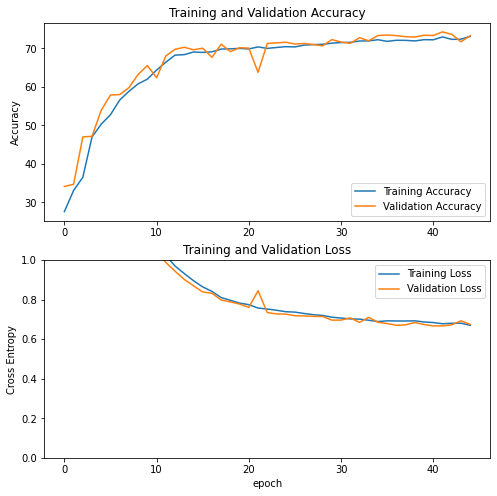

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
torch.save(model, 'v1_apple.pt')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('v1_apple.pth') # Save

import os 
from IPython.display import FileLink
FileLink(r'v1_apple.pth')

import os 
from IPython.display import FileLink
FileLink(r'v1_apple.pt')

/content/v1_apple.pt